# get-residual-plot
6.24.24

Can we plot the residuals? What are some additional comparisons we can do here? We should get rid of the extraneous columns (like the refPool shit) and repeat this analysis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

#### Configs

In [2]:
stem="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/"

# The Lupine ensemble imputed matrix
#lupine_recon_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-30_DE_sandbox/results/lupine-ensemble-imputed.csv"
lupine_recon_path= stem + "results/lupine-ensemble-recon.csv"
lupine_train_annotated_path = stem + "data/lupine-train-pandas.csv"

# The DreamAI imputed quants matrices
dream_imputed_tail = "_dreamAI_recon.csv"
dream_annotated_tail = "_dreamAI_annotated.csv"
dream_test_tail = "_test_dreamAI.csv"

cohorts=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

# For initial filtering of the imputed quants matrix
min_pres=18

#### Read in the Lupine imputed quants

In [3]:
lupine_recon = pd.read_csv(lupine_recon_path, index_col=0)
lupine_train_anno = pd.read_csv(lupine_train_annotated_path, index_col=0)

lupine_recon.index = lupine_train_anno.index
lupine_recon.columns = lupine_train_anno.columns

print(lupine_recon.shape)

(18578, 1905)


#### Init the results dataframe
What do we want to store in here? 

In [4]:
max_len = 561375
lupine_colnames = [x + "_lupine" for x in cohorts]
dream_colnames = [x + "_dreamAI" for x in cohorts]
obs_colnames = [x + "_obs" for x in cohorts]

results = pd.DataFrame(columns=lupine_colnames+dream_colnames+obs_colnames)
res_blank = np.zeros(max_len)
res_blank[:] = np.nan

results["BRCA_lupine"] = res_blank

#### The driver loop
What do we want to do with this? 

In [5]:
for cohort in cohorts:
    print(f"working on: {cohort}")
    
    # Read in the DreamAI imputed quants
    dream_recon = \
        pd.read_csv(stem + "results/" + cohort + dream_imputed_tail, index_col=0)
    dream_train_anno = \
        pd.read_csv(stem + "data/" + cohort + dream_annotated_tail, index_col=0)
    
    # Label the rows and columns
    dream_recon.index = dream_train_anno.index
    dream_recon.columns = dream_train_anno.columns
    
    # Subset both Dream and Lupine by shared proteins and runs
    keep_prots = np.intersect1d(lupine_recon.index, dream_recon.index)

    lupine_recon_trim = lupine_recon[dream_recon.columns].loc[keep_prots]
    dream_recon_trim = dream_recon.loc[keep_prots]

    # Read in and trim the test set
    test_mat = pd.read_csv(stem + "data/" + cohort + dream_test_tail, index_col=0)
    test_mat.index = dream_recon.index
    test_mat.columns = dream_recon.columns
    test_mat_trim = test_mat.loc[keep_prots]
    
    # Get the mask
    test_mask = np.array(np.isnan(test_mat_trim))

    # Isolate just the test set reconstructions for each method
    lupine_mat = np.array(lupine_recon_trim)
    dream_mat = np.array(dream_recon_trim)

    lupine_test_recon = lupine_mat[~test_mask]
    dream_test_recon = dream_mat[~test_mask]

    # Get the actual observed quants as well 
    test_mat_np = np.array(test_mat_trim)
    obs_quants = test_mat_np[~test_mask]

    n_toadd = max_len - len(lupine_test_recon)
    toadd = np.zeros(n_toadd)
    toadd[:] = np.nan

    results[cohort+"_lupine"] = np.concatenate((lupine_test_recon,  toadd))
    results[cohort+"_dreamAI"] = np.concatenate((dream_test_recon, toadd))
    results[cohort+"_obs"] = np.concatenate((obs_quants, toadd))

working on: BRCA
working on: CCRCC
working on: COAD
working on: GBM
working on: HGSC
working on: HNSCC
working on: LSCC
working on: LUAD
working on: PDAC
working on: UCEC


#### Start with observed vs imputed plots for Lupine
4x4 plots, might be overkill

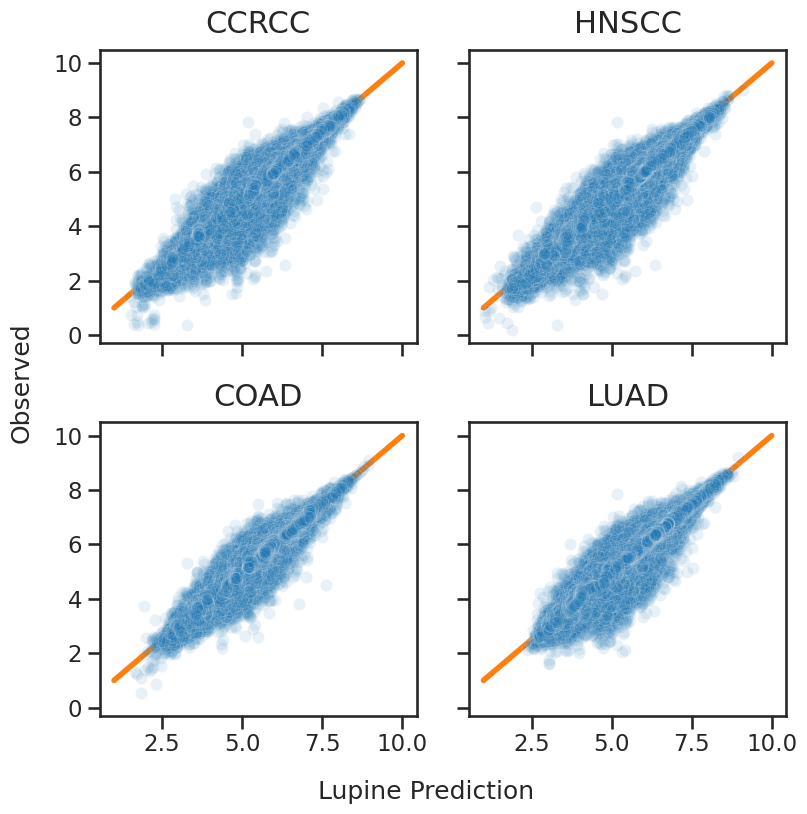

In [6]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

# For the y=x lines
ax_min = 1
ax_max = 10
x = np.linspace(ax_min, ax_max, 100)
y = x

# THE FIRST COMPARISON - CCRCC
sns.scatterplot(
    data=results, 
    x="CCRCC_lupine", 
    y="CCRCC_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0,0],
)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")
ax[0,0].set_title("CCRCC", pad=12, fontsize=22)
ax[0,0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE SECOND COMPARISON - HNSCC
sns.scatterplot(
    data=results, 
    x="HNSCC_lupine", 
    y="HNSCC_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0,1],
)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].set_title("HNSCC", pad=12, fontsize=22)
ax[0,1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE THIRD COMPARISON - COAD
sns.scatterplot(
    data=results, 
    x="COAD_lupine", 
    y="COAD_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1,0],
)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")
ax[1,0].set_title("COAD", pad=12, fontsize=22)
ax[1,0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE FOURTH COMPARISON -- LUAD
sns.scatterplot(
    data=results, 
    x="LUAD_lupine", 
    y="LUAD_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1,1],
)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].set_title("LUAD", pad=12, fontsize=22)
ax[1,1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# This is definitely not the ideal way to do this
fig.text(0.5, -0.02, "Lupine Prediction", ha="center")
fig.text(-0.02, 0.5, "Observed", va="center", rotation="vertical")

fig.tight_layout()

plt.show()
#plt.savefig("../figures/obs-v-lupine-imputed-4way.pdf", bbox_inches="tight")
#plt.savefig("../figures/obs-v-lupine-imputed-4way.png", dpi=250, bbox_inches="tight")

#### Observed vs imputed for DreamAI

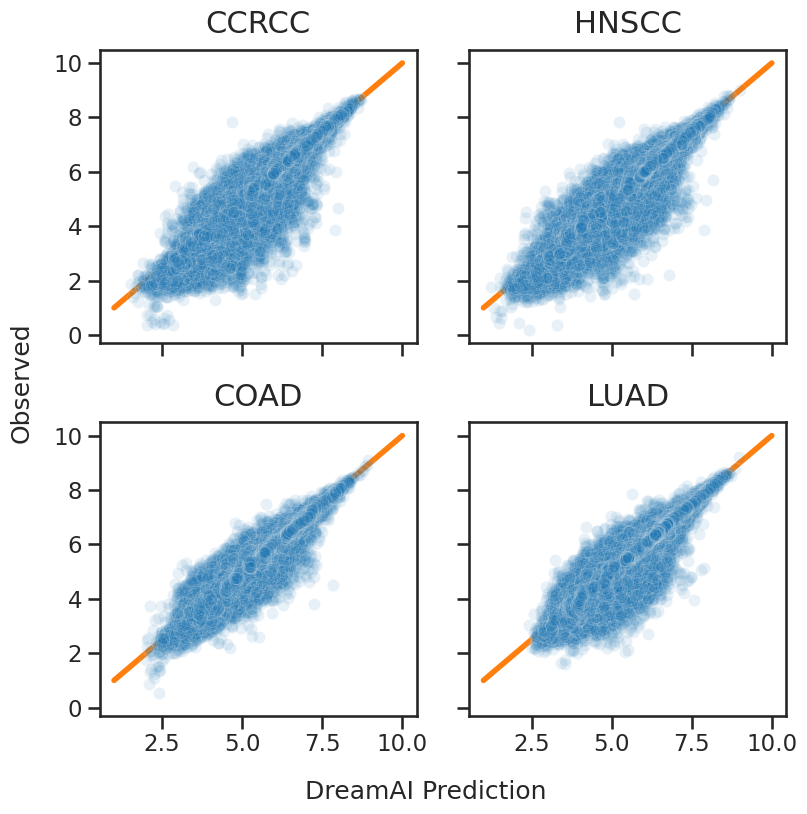

In [7]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

# For the y=x lines
ax_min = 1
ax_max = 10
x = np.linspace(ax_min, ax_max, 100)
y = x

# THE FIRST COMPARISON - CCRCC
sns.scatterplot(
    data=results, 
    x="CCRCC_dreamAI", 
    y="CCRCC_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0,0],
)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")
ax[0,0].set_title("CCRCC", pad=12, fontsize=22)
ax[0,0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE SECOND COMPARISON - HNSCC
sns.scatterplot(
    data=results, 
    x="HNSCC_dreamAI", 
    y="HNSCC_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0,1],
)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].set_title("HNSCC", pad=12, fontsize=22)
ax[0,1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE THIRD COMPARISON - COAD
sns.scatterplot(
    data=results, 
    x="COAD_dreamAI", 
    y="COAD_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1,0],
)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")
ax[1,0].set_title("COAD", pad=12, fontsize=22)
ax[1,0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE FOURTH COMPARISON -- LUAD
sns.scatterplot(
    data=results, 
    x="LUAD_dreamAI", 
    y="LUAD_obs", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1,1],
)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].set_title("LUAD", pad=12, fontsize=22)
ax[1,1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# This is definitely not the ideal way to do this
fig.text(0.5, -0.02, "DreamAI Prediction", ha="center")
fig.text(-0.02, 0.5, "Observed", va="center", rotation="vertical")

fig.tight_layout()

plt.show()
#plt.savefig("../figures/obs-v-lupine-imputed-4way.pdf", bbox_inches="tight")
#plt.savefig("../figures/obs-v-lupine-imputed-4way.png", dpi=250, bbox_inches="tight")

---
## Plot residuals

#### Get the residuals, add to the results dataframe

In [8]:
for cohort in cohorts:
    curr_obs = results[cohort + "_obs"]
    curr_lupine = results[cohort + "_lupine"]
    curr_dream = results[cohort + "_dreamAI"]

    lupine_residual = curr_obs - curr_lupine
    dream_residual = curr_obs - curr_dream

    results[cohort + "_lupine_residual"] = lupine_residual
    results[cohort + "_dream_residual"] = dream_residual

#### Get scatterplots 

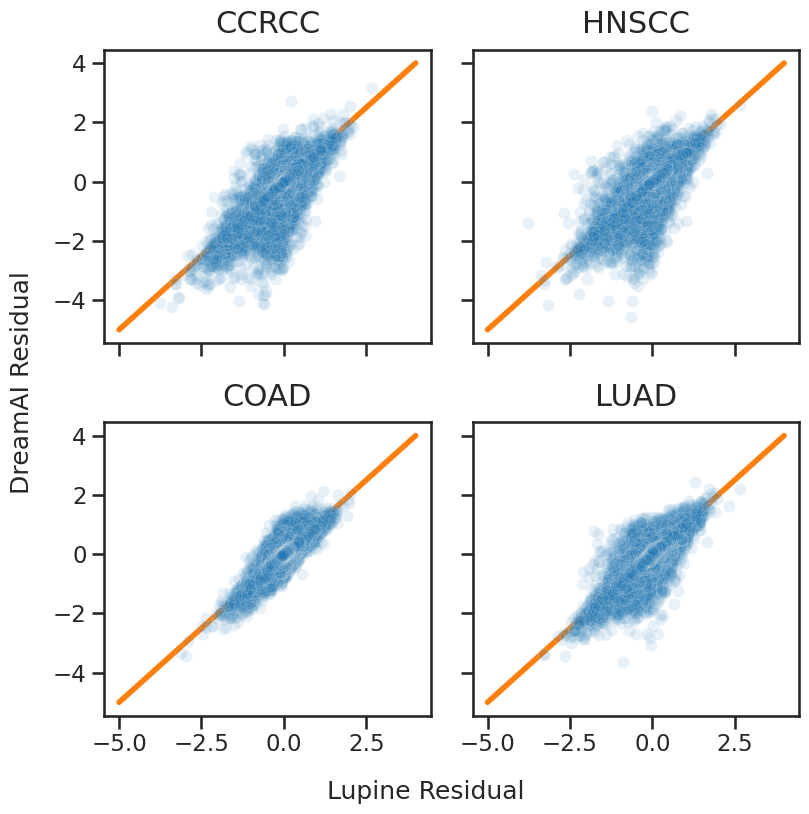

In [9]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

# For the y=x lines
ax_min = -5
ax_max = 4
x = np.linspace(ax_min, ax_max, 100)
y = x

# THE FIRST COMPARISON - CCRCC
sns.scatterplot(
    data=results, 
    x="CCRCC_lupine_residual", 
    y="CCRCC_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0,0],
)
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")
ax[0,0].set_title("CCRCC", pad=12, fontsize=22)
ax[0,0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE SECOND COMPARISON - HNSCC
sns.scatterplot(
    data=results, 
    x="HNSCC_lupine_residual", 
    y="HNSCC_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0,1],
)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].set_title("HNSCC", pad=12, fontsize=22)
ax[0,1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE THIRD COMPARISON - COAD
sns.scatterplot(
    data=results, 
    x="COAD_lupine_residual", 
    y="COAD_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1,0],
)
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")
ax[1,0].set_title("COAD", pad=12, fontsize=22)
ax[1,0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE FOURTH COMPARISON -- LUAD
sns.scatterplot(
    data=results, 
    x="LUAD_lupine_residual", 
    y="LUAD_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1,1],
)
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")
ax[1,1].set_title("LUAD", pad=12, fontsize=22)
ax[1,1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# This is definitely not the ideal way to do this
fig.text(0.5, -0.02, "Lupine Residual", ha="center")
fig.text(-0.02, 0.5, "DreamAI Residual", va="center", rotation="vertical")

fig.tight_layout()

plt.show()
#plt.savefig("../figures/lupine-v-dream-residuals.pdf", bbox_inches="tight")
#plt.savefig("../figures/lupine-v-dream-residuals.png", dpi=250, bbox_inches="tight")

#### Try a 3-up plot? 

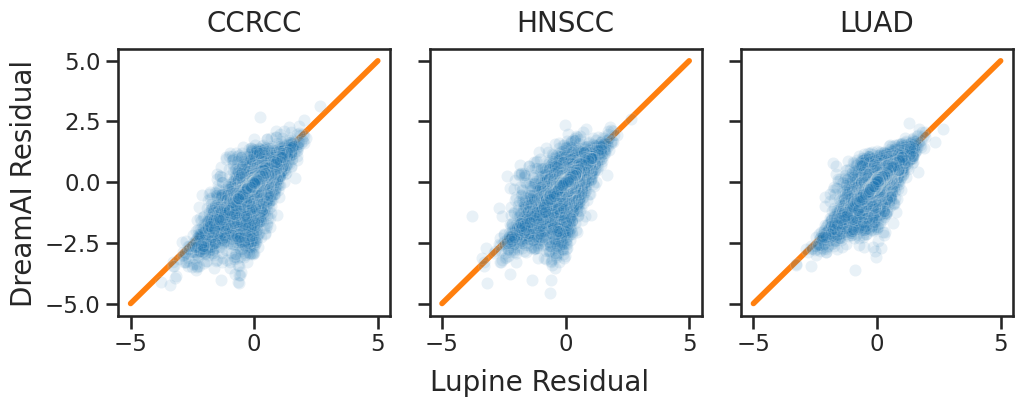

In [10]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))

# For the y=x lines
ax_min = -5
ax_max = 5
x = np.linspace(ax_min, ax_max, 100)
y = x

# THE FIRST COMPARISON - CCRCC
sns.scatterplot(
    data=results, 
    x="CCRCC_lupine_residual", 
    y="CCRCC_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0],
)
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("CCRCC", pad=12, fontsize=20)
ax[0].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE SECOND COMPARISON - HNSCC
sns.scatterplot(
    data=results, 
    x="HNSCC_lupine_residual", 
    y="HNSCC_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1],
)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("HNSCC", pad=12, fontsize=20)
ax[1].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# THE THIRD COMPARISON - LUAD
sns.scatterplot(
    data=results, 
    x="LUAD_lupine_residual", 
    y="LUAD_dream_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[2],
)
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_title("LUAD", pad=12, fontsize=20)
ax[2].plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# Add shared axis names
fig.text(0.5, -0.02, "Lupine Residual", ha="center", size=20)
fig.text(-0.03, 0.5, "DreamAI Residual", va="center", rotation="vertical", size=20)

fig.tight_layout()

plt.show()
#plt.savefig("../figures/lupine-v-dream-residuals-v1.pdf", bbox_inches="tight")
#plt.savefig("../figures/lupine-v-dream-residuals.png", dpi=250, bbox_inches="tight")

#### Flip the axes, so that this matches panel A from the figure

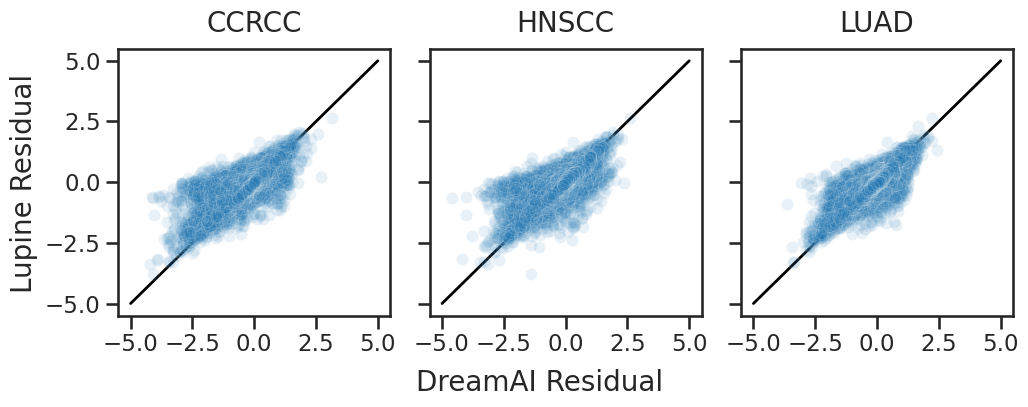

In [11]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))

# For the y=x lines
ax_min = -5
ax_max = 5
x = np.linspace(ax_min, ax_max, 100)
y = x

# THE FIRST COMPARISON - CCRCC
sns.scatterplot(
    data=results, 
    x="CCRCC_dream_residual", 
    y="CCRCC_lupine_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0],
)
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("CCRCC", pad=12, fontsize=20)
ax[0].plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# THE SECOND COMPARISON - HNSCC
sns.scatterplot(
    data=results, 
    x="HNSCC_dream_residual", 
    y="HNSCC_lupine_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1],
)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("HNSCC", pad=12, fontsize=20)
ax[1].plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# THE THIRD COMPARISON - LUAD
sns.scatterplot(
    data=results, 
    x="LUAD_dream_residual", 
    y="LUAD_lupine_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[2],
)
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_title("LUAD", pad=12, fontsize=20)
ax[2].plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# Add shared axis names
fig.text(0.5, -0.02, "DreamAI Residual", ha="center", size=20)
fig.text(-0.03, 0.5, "Lupine Residual", va="center", rotation="vertical", size=20)

fig.tight_layout()

ax[2].locator_params(axis='x', nbins=5)
ax[2].locator_params(axis='y', nbins=5)

#plt.show()
#plt.savefig("../figures/lupine-v-dream-residuals-v2.pdf", bbox_inches="tight")
#plt.savefig("../figures/lupine-v-dream-residuals-v2.png", dpi=250, bbox_inches="tight")

---
## How many Xijs is Lupine better than DreamAI for? And worse? 
The best thing might honestly be to calculate these as percentages and annotate each plot with them. 

#### For CCRCC

In [75]:
# Get the absolute values of the residuals
lupine_ccrcc_res = np.array(np.abs(results["CCRCC_lupine_residual"]))
dream_ccrcc_res = np.array(np.abs(results["CCRCC_dream_residual"]))

# Get the locations of the NaNs, in both arrays
nans = np.isnan(lupine_ccrcc_res) | np.isnan(dream_ccrcc_res)

# Remove the NaNs
lupine_ccrcc_res1 = lupine_ccrcc_res[~nans]
dream_ccrcc_res1 = dream_ccrcc_res[~nans]

# Sanity check
print(len(lupine_ccrcc_res1))
print(len(dream_ccrcc_res1))
print("")

# Limit the analysis to "hard ones"
keep_idx = (lupine_ccrcc_res1 > 0.25) | (dream_ccrcc_res1 > 0.25)
lupine_ccrcc_res2 = lupine_ccrcc_res1[keep_idx]
dream_ccrcc_res2 = dream_ccrcc_res1[keep_idx]

lupine_wins_ccrcc = np.count_nonzero(lupine_ccrcc_res2 < dream_ccrcc_res2)
lupine_wins_ccrcc_frac = lupine_wins_ccrcc / len(lupine_ccrcc_res2)
print(np.around(lupine_wins_ccrcc_frac, 3))

455770
455770

0.641


#### For HNSCC

In [74]:
# Get the absolute values of the residuals
lupine_hnscc_res = np.array(np.abs(results["HNSCC_lupine_residual"]))
dream_hnscc_res = np.array(np.abs(results["HNSCC_dream_residual"]))

# Get the locations of the NaNs, in both arrays
nans = np.isnan(lupine_hnscc_res) | np.isnan(dream_hnscc_res)

# Remove the NaNs
lupine_hnscc_res1 = lupine_hnscc_res[~nans]
dream_hnscc_res1 = dream_hnscc_res[~nans]

# Sanity check 
print(len(lupine_hnscc_res1))
print(len(dream_hnscc_res1))
print("")

# Limit the analysis to "hard ones"
keep_idx = (lupine_hnscc_res1 > 0.25) | (dream_hnscc_res1 > 0.25)
lupine_hnscc_res2 = lupine_hnscc_res1[keep_idx]
dream_hnscc_res2 = dream_hnscc_res1[keep_idx]

# Compare 
lupine_wins_hnscc = np.count_nonzero(lupine_hnscc_res2 < dream_hnscc_res2)
lupine_wins_hnscc_frac = lupine_wins_hnscc / len(lupine_hnscc_res2)
print(np.around(lupine_wins_hnscc_frac, 3))

445097
445097

0.614


### And for LUAD

In [72]:
# Get the absolute values of the residuals
lupine_luad_res = np.array(np.abs(results["LUAD_lupine_residual"]))
dream_luad_res = np.array(np.abs(results["LUAD_dream_residual"]))

# Get the locations of the NaNs, in both arrays
nans = np.isnan(lupine_luad_res) | np.isnan(dream_luad_res)

# Remove the NaNs
lupine_luad_res1 = lupine_luad_res[~nans]
dream_luad_res1 = dream_luad_res[~nans]

# Sanity check 
print(len(lupine_luad_res1))
print(len(dream_luad_res1))
print("")

# Limit the analysis to "hard ones"
keep_idx = (lupine_luad_res1 > 0.25) | (dream_luad_res1 > 0.25)
lupine_luad_res2 = lupine_luad_res1[keep_idx]
dream_luad_res2 = dream_luad_res1[keep_idx]

# Compare 
lupine_wins_luad = np.count_nonzero(lupine_luad_res2 < dream_luad_res2)
lupine_wins_luad_frac = lupine_wins_luad / len(lupine_luad_res2)
print(np.around(lupine_wins_luad_frac, 3))

556444
556444

0.606


#### Redo side-by-side scatterplots, with percentages

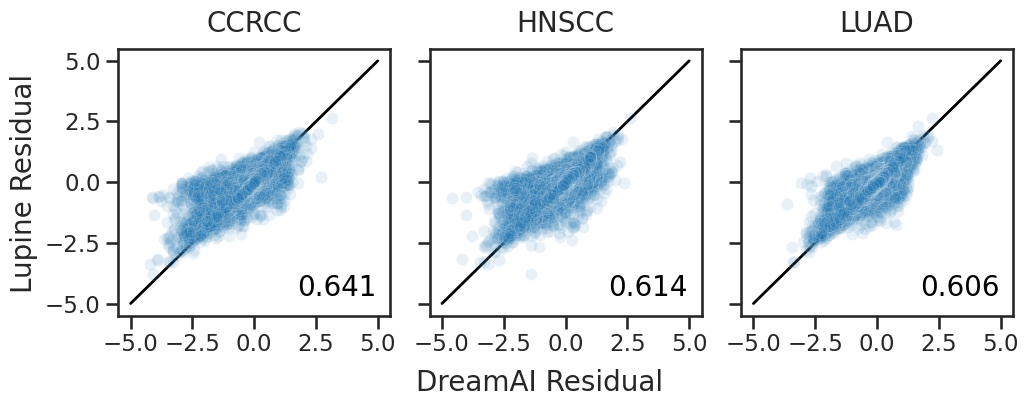

In [84]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))

# For the y=x lines
ax_min = -5
ax_max = 5
x = np.linspace(ax_min, ax_max, 100)
y = x

# THE FIRST COMPARISON - CCRCC
sns.scatterplot(
    data=results, 
    x="CCRCC_dream_residual", 
    y="CCRCC_lupine_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[0],
)
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("CCRCC", pad=12, fontsize=20)
ax[0].plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# Add the percentage of Lupine wins (CCRCC)
ax[0].text(
    0.95, 0.05, 
    np.around(lupine_wins_ccrcc_frac, 3),
    verticalalignment="bottom",
    horizontalalignment="right",
    transform=ax[0].transAxes, 
    color="black", 
    fontsize=20,
)

# THE SECOND COMPARISON - HNSCC
sns.scatterplot(
    data=results, 
    x="HNSCC_dream_residual", 
    y="HNSCC_lupine_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[1],
)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("HNSCC", pad=12, fontsize=20)
ax[1].plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# Add the percentage of Lupine wins (HNSCC)
ax[1].text(
    0.95, 0.05, 
    np.around(lupine_wins_hnscc_frac, 3),
    verticalalignment="bottom",
    horizontalalignment="right",
    transform=ax[1].transAxes, 
    color="black", 
    fontsize=20,
)

# THE THIRD COMPARISON - LUAD
sns.scatterplot(
    data=results, 
    x="LUAD_dream_residual", 
    y="LUAD_lupine_residual", 
    alpha=0.1, 
    s=75, 
    zorder=2, 
    ax=ax[2],
)
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_title("LUAD", pad=12, fontsize=20)
ax[2].plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# Add the percentage of Lupine wins (LUAD)
ax[2].text(
    0.95, 0.05, 
    np.around(lupine_wins_luad_frac, 3),
    verticalalignment="bottom",
    horizontalalignment="right",
    transform=ax[2].transAxes, 
    color="black", 
    fontsize=20,
)

# Add shared axis names
fig.text(0.5, -0.02, "DreamAI Residual", ha="center", size=20)
fig.text(-0.03, 0.5, "Lupine Residual", va="center", rotation="vertical", size=20)

fig.tight_layout()

ax[2].locator_params(axis='x', nbins=5)
ax[2].locator_params(axis='y', nbins=5)

plt.show()
#plt.savefig("../figures/lupine-v-dream-residuals-v2.pdf", bbox_inches="tight")
#plt.savefig("../figures/lupine-v-dream-residuals-v2.png", dpi=250, bbox_inches="tight")